<a href="https://colab.research.google.com/github/yee030/image_cifar_tutorial/blob/main/%EC%9D%B4%EB%AF%B8%EC%A7%80%EB%B6%84%EB%A5%98_cifar_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
# 데이터 변환을 정의. 이미지를 PyTorch 텐서로 변환하고, 각 채널에 대해 평균이 0.5이고 표준 편차가 0.5가 되도록 이미지를 정규화.
transform = transforms.Compose(
    [transforms.ToTensor(),  # 이미지를 PyTorch 텐서로 변환
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # 이미지를 정규화

batch_size = 4  # 훈련 및 테스트 데이터를 미니배치로 나눌 때 사용할 배치 크기를 정의.

# CIFAR10 훈련 데이터셋을 로드하고 정의한 데이터 변환(transform)을 적용.
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# 훈련 데이터를 미니배치로 나누고 섞어주기. 또한 병렬 처리를 위해 여러 작업자(num_workers)를 사용하기.
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# CIFAR10 테스트 데이터셋을 로드하고 정의한 데이터 변환(transform)을 적용하기.
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
# 테스트 데이터를 미니배치로 나누고 섞지 않기. 병렬 처리를 위해 여러 작업자(num_workers)를 사용하기.
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# CIFAR10 데이터셋의 클래스 레이블을 정의하기.
classes = ('비행기', '자동차', '새', '고양이',
           '사슴', '개', '개구리', '말', '배', '트럭')


100%|██████████| 170498071/170498071 [00:03<00:00, 43564546.35it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


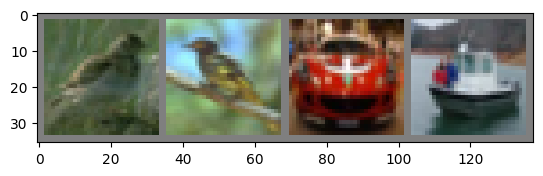

새     새     자동차   배    


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 표시하는 함수 정의

def imshow(img):
    img = img / 2 + 0.5  # 이미지를 언노멀라이즈 (픽셀 값 범위를 [0, 1]에서 [-1, 1]로 변환)
    npimg = img.numpy()  # PyTorch 텐서를 NumPy 배열로 변환
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # 이미지를 표시하기 위해 채널 순서를 변환하고 플로팅
    plt.show()

# 무작위 훈련 이미지 가져오기
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 이미지 표시
imshow(torchvision.utils.make_grid(images))  # 이미지 그리드를 생성하고 표시
# 레이블 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))  # 이미지에 대한 클래스 레이블 출력


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# 신경망 아키텍처를 정의하는 클래스 생성
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional Layer 1: 입력 채널 3 (RGB 이미지), 출력 채널 6, 커널 크기 5x5
        self.conv1 = nn.Conv2d(3, 6, 5)
        # Max Pooling Layer: 최대 풀링, 커널 크기 2x2
        self.pool = nn.MaxPool2d(2, 2)
        # Convolutional Layer 2: 입력 채널 6, 출력 채널 16, 커널 크기 5x5
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Fully Connected Layer 1: 입력 크기 16x5x5, 출력 크기 120
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # Fully Connected Layer 2: 입력 크기 120, 출력 크기 84
        self.fc2 = nn.Linear(120, 84)
        # Fully Connected Layer 3 (Output Layer): 입력 크기 84, 출력 크기 10 (클래스 수)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # 입력 데이터를 통해 순전파 수행
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 -> ReLU -> Max Pooling
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 -> ReLU -> Max Pooling
        x = torch.flatten(x, 1)  # Flatten: 다차원 데이터를 1차원으로 펼침 (배치를 제외한 모든 차원)
        x = F.relu(self.fc1(x))  # FC1 -> ReLU
        x = F.relu(self.fc2(x))  # FC2 -> ReLU
        x = self.fc3(x)  # FC3 (Output Layer)
        return x

# Net 클래스의 인스턴스 생성 (신경망 모델)
net = Net()


In [ ]:
import torch.optim as optim

# 손실 함수 (Loss Function) 정의: 크로스 엔트로피 손실 (Cross-Entropy Loss)
criterion = nn.CrossEntropyLoss()

# 최적화 알고리즘 선택: 확률적 경사 하강법 (Stochastic Gradient Descent, SGD)
# net.parameters()로 모델의 가중치 및 편향을 전달하고, 학습률(learning rate) 및 모멘텀(momentum) 값을 설정
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [ ]:
# 데이터셋을 여러 번 반복하여 훈련하는 루프 (에폭(epoch) 수행)
for epoch in range(2):  # 데이터셋을 2번 반복하여 훈련합니다. (임의의 에폭 수)

    running_loss = 0.0  # 현재 에폭에서의 손실을 저장하는 변수
    for i, data in enumerate(trainloader, 0):
        # 데이터를 가져옵니다. data는 [입력, 레이블]의 리스트입니다.
        inputs, labels = data

        # 기울기를 초기화합니다. (이전 미분 값 초기화)
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화
        outputs = net(inputs)  # 신경망에 입력 데이터를 전달하여 출력을 얻습니다.
        loss = criterion(outputs, labels)  # 예측과 실제 레이블 간의 손실을 계산합니다.
        loss.backward()  # 역전파: 손실에 대한 기울기를 계산하여 역전파합니다.
        optimizer.step()  # 최적화: 가중치 및 편향을 업데이트하여 손실을 최소화합니다.

        # 통계 정보 출력
        running_loss += loss.item()  # 현재 미니배치의 손실을 누적합니다.
        if i % 2000 == 1999:  # 매 2000 미니배치마다 손실을 출력합니다.
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

# 훈련 종료 메시지 출력
print('Finished Training')


[1,  2000] loss: 2.236
[1,  4000] loss: 1.881
[1,  6000] loss: 1.698
[1,  8000] loss: 1.570
[1, 10000] loss: 1.519
[1, 12000] loss: 1.439
[2,  2000] loss: 1.377
[2,  4000] loss: 1.342
[2,  6000] loss: 1.356
[2,  8000] loss: 1.323
[2, 10000] loss: 1.307
[2, 12000] loss: 1.301
Finished Training


In [ ]:
# 모델 가중치 및 설정을 저장할 파일 경로를 정의합니다.
PATH = './cifar_net.pth'

# 모델의 상태 사전을 파일로 저장합니다.
torch.save(net.state_dict(), PATH)


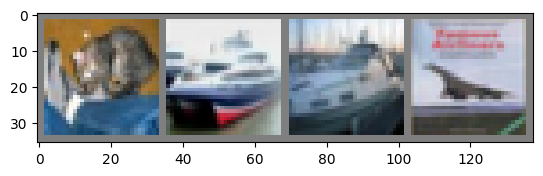

GroundTruth:  고양이   배     배     비행기  


In [ ]:
# 테스트 데이터 로더에서 무작위로 미니배치를 가져옵니다.
dataiter = iter(testloader)
images, labels = next(dataiter)

# 이미지를 표시합니다.
imshow(torchvision.utils.make_grid(images))  # 이미지 그리드를 생성하고 표시합니다.

# 실제 레이블을 출력합니다.
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))


In [ ]:
# 새로운 신경망 모델을 인스턴스화합니다.
net = Net()

# 미리 저장된 모델의 가중치와 설정을 로드합니다.
net.load_state_dict(torch.load(PATH))


<All keys matched successfully>

In [ ]:
# 신경망에 입력 데이터를 전달하여 예측을 생성합니다.
outputs = net(images)


In [ ]:
# 모델의 출력에서 가장 높은 값(가장 확률이 높은 클래스)과 해당 클래스의 인덱스를 찾습니다.
_, predicted = torch.max(outputs, 1)

# 예측된 클래스 레이블을 출력합니다.
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))


Predicted:  고양이   자동차   자동차   비행기  


In [ ]:
correct = 0  # 올바르게 분류된 예측 수를 저장하는 변수
total = 0    # 전체 데이터 포인트 수를 저장하는 변수

# 모델을 훈련하지 않기 때문에 출력의 기울기를 계산할 필요가 없습니다.
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # 네트워크를 통해 이미지를 전달하여 출력 계산
        outputs = net(images)
        # 에너지(출력 값)가 가장 높은 클래스를 예측값으로 선택합니다.
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)  # 전체 데이터 포인트 수를 누적
        # 정확하게 예측한 경우 올바르게 분류된 예측 수를 누적
        correct += (predicted == labels).sum().item()

# 네트워크의 정확도를 계산하고 출력합니다.
accuracy = 100 * correct // total  # 정확하게 분류된 예측의 비율을 백분율로 계산
print(f'Accuracy of the network on the 10000 test images: {accuracy} %')


Accuracy of the network on the 10000 test images: 54 %


In [ ]:
# 각 클래스에 대한 예측을 카운트할 변수들을 준비합니다.
correct_pred = {classname: 0 for classname in classes}  # 각 클래스별로 올바르게 예측한 수를 저장
total_pred = {classname: 0 for classname in classes}   # 각 클래스별로 전체 예측 수를 저장

# 다시 한 번 기울기(그래디언트)를 필요로 하지 않습니다.
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 클래스에 대한 정확한 예측을 수집합니다.
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# 각 클래스별 정확도를 출력합니다.
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Accuracy for class: 비행기   is 73.0 %
Accuracy for class: 자동차   is 66.2 %
Accuracy for class: 새     is 38.7 %
Accuracy for class: 고양이   is 28.2 %
Accuracy for class: 사슴    is 49.0 %
Accuracy for class: 개     is 44.2 %
Accuracy for class: 개구리   is 78.1 %
Accuracy for class: 말     is 45.4 %
Accuracy for class: 배     is 51.1 %
Accuracy for class: 트럭    is 70.2 %


In [ ]:
# 사용 가능한 경우 CUDA 장치를 사용하고, 그렇지 않은 경우 CPU를 사용합니다.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 만약 CUDA 장치가 사용 가능한 경우, 'cuda:0'와 같은 CUDA 디바이스를 출력합니다.
print(device)


cpu


In [ ]:
del dataiter